In [1]:
from os.path import join
import torch 
torch.manual_seed(2)

from copy import deepcopy

import numpy as np
np.random.seed(2)

import matplotlib.pyplot as plt
plt.rcParams['font.family']= 'open sans'

from rdn.fitting.models import LocalGaussModelTilde
from rdn.defaults import pardict_from_result

from rdn.validation import Simulation

# Figure 5

In [2]:
model = LocalGaussModelTilde()

model_p_dict = pardict_from_result(
    'output/multi_fitting/Multi_LocalGaussModelTilde/NLLAdast/1_3_5_7_Spine_data_fides_1200.hdf5', 
    Chi=1, dendrite_length=1000, N_mean=5000, run_index=0)



Basal K distribution:
- Sample size: 59
- Mean: 4017.7537474693586 +- 2746.5237188826472
- Anderson test on log: AndersonResult(statistic=np.float64(0.36243150482356157), critical_values=array([0.543, 0.619, 0.742, 0.866, 1.03 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=np.float64(8.106764691950193), scale=np.float64(0.6245301761906116))
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

Basal N distribution:
- Sample size: 58
- Mean: 8070.943955026876 +- 5225.598876296613
- Anderson test on log: AndersonResult(statistic=np.float64(0.5003716373876728), critical_values=array([0.543, 0.618, 0.741, 0.865, 1.029]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=np.float64(8.820978310112448), scale=np.float64(0.5968557991311232))
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

Correlation matrix between log K_b and log

This can all be wrapped in a bit plotter function. Lets see the simulations

# Plasticity profiles


In [3]:
rng = np.random.default_rng(2025)

log_samples = rng.multivariate_normal(
    model_p_dict['mu_log_K_N'], 
    model_p_dict['cov_log_K_N'],
    size=10000    
)

samples = np.exp(log_samples)
MEANS_K_V = np.mean(samples, axis=0)

In [4]:
def induction_profile(mpd, x, stim_idxes, K_or_N):
    '''Value of the induced catalyst (K or N) per each position
    kn: str (the key to use for the dict)
    '''

    total = np.zeros_like(x, dtype=float)

    for xs in stim_idxes:
        total += (
            mpd[f'{K_or_N}s'] * 
            np.exp(-(x-xs)**2/mpd[f'sigma_{K_or_N}'])
        )

    return total*np.exp(-2/mpd[f'tau_{K_or_N}'])/10000


def compute_stimulus_orthogonal_component(kx, nx):
    '''
    kx, nx: arrays containing the contributed k and n at each position
    '''

    basal_vec = np.pad(MEANS_K_V, (0,1))
    basal_vec_norm = np.linalg.norm(basal_vec)**0.5

    orthogonal_component = np.array([
        np.cross(i, basal_vec)/basal_vec_norm for i in zip(
            kx, nx, np.zeros_like(kx)
        )
    ]).T[-1]

    return orthogonal_component


def compute_post_basal_rotation_angles(kx, nx):
    '''
    kx, nx: arrays containing the contributed k and n at each position
    '''

    basal_vec = np.pad(MEANS_K_V, (0,1))
    basal_vec_norm = np.linalg.norm(basal_vec)**0.5
    post_vec = np.array([i + basal_vec for i in zip(
        kx, nx, np.zeros_like(kx)
    )])
    post_vec_norm = np.linalg.norm(post_vec)**0.5


    post_basal_sin = (
        np.linalg.cross(post_vec, basal_vec)
        / basal_vec_norm / post_vec_norm
    ).T[-1]

    post_basal_rotation_angles = np.arcsin(post_basal_sin)

    # print(f'{basal_vec=}, {basal_vec_norm=}')
    # print(f'{post_vec[0]=}, {post_vec_norm=}')
    # print(f'{kx[0]=}, {nx[0]=}')
    # print(f'{post_basal_rotation[0]=}')

    return post_basal_rotation_angles

In [5]:
def plot_plasticity_profile(ax, rel_sizes_batch):
    '''Default plotter for data generated with the simulation'''

    spine_number = rel_sizes_batch.shape[1]

    X_fine = np.linspace(0,spine_number,100)
    X = np.arange(0,spine_number)

    qs = torch.tensor([0.25,0.5,0.75], dtype=torch.float64)

    q1, Y, q3 = torch.quantile(
        rel_sizes_batch[2,:,:],
        qs,
        axis=1,
        keepdim=True,
    )

    ax.errorbar(
        X,Y, fmt='-o',
        linewidth=1,
    )
    
    ax.fill_between(
        X,
        q1.squeeze(),
        q3.squeeze(),
        alpha=0.2
    )

    ax.axhline(y=1, linestyle=(0,(12,6)), c='black', linewidth=0.5)

    for k,v in ax.spines.items():
        if k != 'left': v.set_visible(False)

    ax.set_xticks((2,5,8), (-3,0,3))
    ax.set_xlabel(r'Spine position $[\mu m]$')

    ax.set_ylim(0.5,2)
    ax.set_yticks((0.5,1,1.5,2))
    ax.set_ylabel('Post-basal\nratio')


def plot_catalyst_induction_profile(ax, mpd, stim_idxes, spine_number):
    x_fine = np.linspace(0,spine_number, 1000)

    ks = induction_profile(mpd, x_fine, stim_idxes, 'K')
    ns = induction_profile(mpd, x_fine, stim_idxes, 'N')

    ax.plot(x_fine, ks, c='forestgreen')
    ax.plot(x_fine, ns, c='mediumvioletred')
    ax.axhline(y=0, linestyle=(0,(12,6)), c='black', linewidth=0.5)
    
    for k,v in ax.spines.items():
        if k != 'left': v.set_visible(False)

    ax.set_xticks((2,5,8), (-3,0,3))
    ax.set_xlabel(r'Spine position $[\mu m]$')

    ax.set_ylim(-0.1,3)
    ax.set_yticks((0,3),(0.0,3.0))
    ax.set_ylabel(r'$10^4$ units')



def analyze_plasticity_column(axs, mpd, stim_idxes, spine_number):
    # Simulate
    simulation = Simulation(model = model,
                    model_p_dict = mpd,
                    simulation_time = 40,
                    spine_number = spine_number,
                    inter_spine_distance = 1,
                    stim_indexes = stim_idxes
                    )

    _,_,rsb, _,kbs, _,nbs = simulation.run_return_all(100, seed=1)
    
    # Probably bad and unnecessary, like this whole infrastructure
    if len(axs)>0:
        plot_plasticity_profile(axs[0], rsb)
    if len(axs)>1:
        plot_catalyst_induction_profile(axs[1], mpd, stim_idxes, spine_number)
        axs[0].set_xlabel('')
        axs[0].set_xticks([])
    if len(axs)>2: 
        plot_orthogonal_components(axs[2], mpd, stim_idxes, spine_number)
        axs[1].set_xlabel('')
        axs[1].set_xticks([])


    for ax in axs:
        ax.set_xlim(0,10)
        for k,v in ax.spines.items():
            if k != 'left': v.set_visible(False)





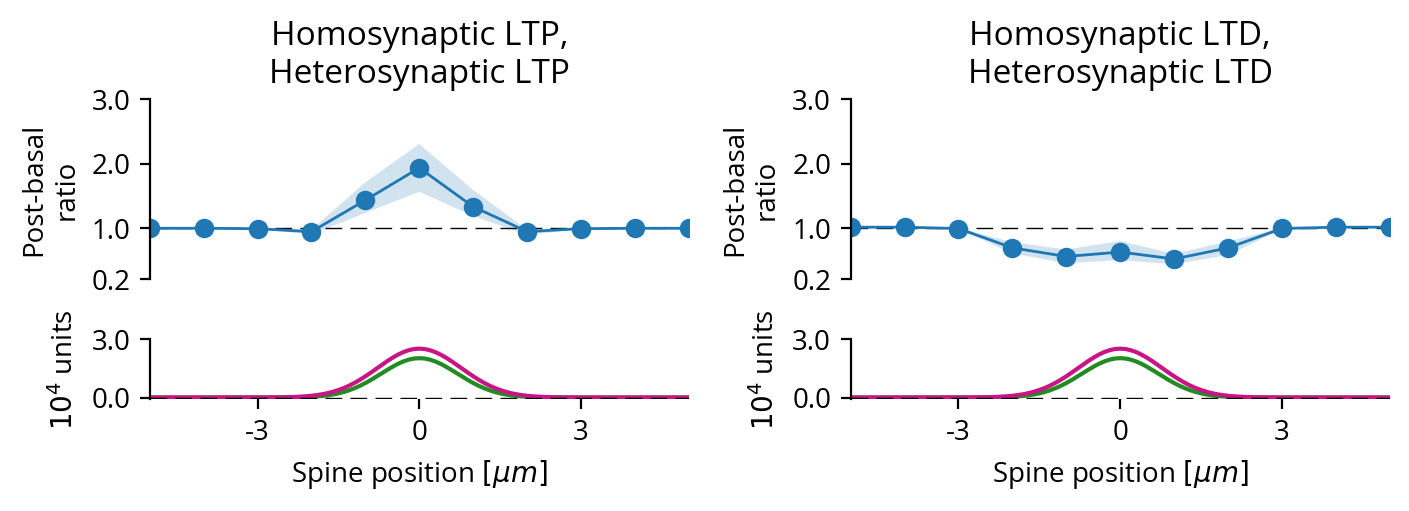

In [6]:
fig, axs = plt.subplots(2,2, figsize=(8,3), height_ratios=(3,1),dpi=200)
fig.subplots_adjust(wspace=0.3, hspace=0.5, bottom=0.3, top=0.8)


mpd = deepcopy(model_p_dict)
mpd['mu_log_K_N'][0] -= 0.35
mpd['mu_log_K_N'][1] += 0
analyze_plasticity_column(axs[:,0], mpd, [5,], 100)

mpd = deepcopy(model_p_dict)
mpd['mu_log_K_N'][0] -= 0
mpd['mu_log_K_N'][1] -= 1
analyze_plasticity_column(axs[:,1], mpd, [5,], 100)


axs[0,0].set_title('Homosynaptic LTP,\nHeterosynaptic LTP')
axs[0,1].set_title('Homosynaptic LTD,\nHeterosynaptic LTD')

for ax in axs[0]:
    ax.set_ylim(0.2,3)
    ax.set_yticks((0.2,1,2,3))

# plt.savefig('docs/figures-paper/single-panels/hetero/myneighbour-basal.svg')
